# H1C IDR3.2 JD and Triad Metrics

In [1]:
import os
import h5py
import numpy as np

import sys
sys.path.append("/users/pkeller/code/ClosurePhaseAnalysis/")

from library import cptools as cp
from library import cpplots as plot

from ipywidgets import interact

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# configure matplotlib
mpl.style.use("classic")

## Load Data
Load Bispectrum Data. Meta data is printed below cell.

In [2]:
path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ28_FD_B2.h5"

with h5py.File(path, "r") as f:
    jd = f["JD"][()]
    lst = f["LST"][()]
    frq = f["FRQ"][()]
    bispec = f["bispec"][()]
    trlist = f["triads"][()]

# generate frequency array
fmin, fmax, fN = (100, 200, 1024)
df = (fmax - fmin) / fN

# time data
jdmin, jdmax = np.min(jd), np.max(jd)
lstmin, lstmax, lstN = np.min(lst), np.max(lst), len(lst)
dt = (lstmax - lstmin) * 3600 / lstN

print(f"data has shape {bispec.shape}")
print(f"JD range {jdmin}-{jdmax}, {len(jd)} nights")
print(r"LST range {:.2f}-{:.2f} h, integration time {:.2f} s".format(lstmin, lstmax, dt))
print(r"frequency range {:.2f}-{:.2f} MHz, channel width {:.4f} MHz".format(min(frq), max(frq), df))

data has shape (2, 167, 70, 1004, 161)
JD range 2458032-2458207, 167 nights
LST range 6.25-9.25 h, integration time 10.76 s
frequency range 152.30-167.94 MHz, channel width 0.0977 MHz


## LST-averaging
Average neighbouring timer-integrations (n=12 ~ 2 min) of the bispectrum using the mean.

In [17]:
n = 12

bispec = np.moveaxis(bispec, 3, 0)
bispec = np.array([np.nanmean(bispec[i*n:(i+1)*n], axis=0) for i in range(len(lst) // n)])
bispec = np.moveaxis(bispec, 0, 3)

lst = np.array([np.nanmean(lst[i*n:(i+1)*n], axis=0) for i in range(len(lst) // n)])

print(f"data has shape {bispec.shape}")
print(r"new integration time {:.2f} s".format(n*dt))

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


data has shape (2, 167, 70, 83, 161)
new integration time 129.07 s


## Geometric Median over Triads

In [ ]:
import imp; imp.reload(cp)
shape = bispec.shape[:2] + bispec.shape[3:]
mbispec = np.zeros(shape).astype(np.complex128)

for j in range(len(jd)):
    mbispec[:, j] = cp.geomed(bispec[:, j], axis=1)
                
print("median data has shape {}".format(mbispec.shape))

### Plot Median Bispectrum over Triads
The median bispectrum over triads allows to inspect different days for RFI. The plot below helps to identify these bad JD

In [ ]:
bispecJD = np.nanmean(mbispec, axis=0)

In [27]:
def plot(j):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    im1 = ax[0].imshow(
        np.angle(bispecJD[j]),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto",
    )
    im2 = ax[1].imshow(
        np.abs(bispecJD[j]),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.bone,
        interpolation="None",
        aspect="auto",
        vmin=0, 
        vmax=1e-4,
    )
    
    ax[0].set_title(f"JD {jd[j]}, Bispectrum Phase")
    ax[1].set_title(f"JD {jd[j]}, Bispectrum Amplitude")
    plt.setp(ax, xlabel="Frequency (MHz)", ylabel="LST (h)", ylim=[min(lst), max(lst)])
    
    plt.tight_layout()
    plt.show()

interact(plot, j=(0, len(jd)-1, 1))

interactive(children=(IntSlider(value=83, description='j', max=166), Output()), _dom_classes=('widget-interact…

<function __main__.plot(j)>

## Manual Flagging
E.g. JDs affected by broadband RFI

In [ ]:
# JDs affected by RFI
flags = np.zeros(bispec.shape[:-1])
badjd = 2458000 + np.array([206, 188, 184, 179, 178, 173, 172, 170, 169, 168, 167, 166, 165, 163, 162, 159, 156, 141, 137, 57], dtype=int)
badjd = np.where(np.in1d(jd, badjd))
flags[:, badjd] = 1

## Flag LST 
E.g. integrations that repeat themselves

In [ ]:
for j, bisp in enumerate(bispecJD):
    for i in range(1, len(bisp)-1):
        if np.isclose(bisp[i], bisp[i-1]).all() or np.isclose(bisp[i], bisp[i+1]).all():
            flags[:, j, :, i] = 1
            flags[:, j, :, i-1] = 1
            flags[:, j, :, i+1] = 1
            
bispec[flags.astype(bool)] = np.nan
bispecJD[flags.mean(axis=(0, 2)).astype(bool)] = np.nan

## Metric: No-Signal
Some closure phase triads don't show any sky signal (white noise only). The purpose of this metric is to identify these triads on a per day and polarisation basis. The time it takes to compute the metric is of order ~10 minutes. The metric is calculated as

$z_{i} = \frac{2}{\pi} \mathrm{med} \{\phi_{i, t, \nu} - \mathrm{med} \{ \phi_{i, t, \nu} \}_{i} + \xi_{i, t, \nu}\}_{t, \nu}$,

where $i$, $t$ and $\nu$ are the triad number the time and the frequency respectively and $\xi \in \{-2 \pi, 0, 2 \pi \}$ account for the circularity of the phase. The innermost median is actually a geometric median on the bispectrum which naturally takes into account the circularity of the phase. For a statistically random phase the value of the metric will be close to 1. The better the redundancy of a triad with respect to the other triads, the closer it's $z_i$ will be to zero.

In [28]:
z = np.nanmedian(np.abs(cp.phase_diff(np.moveaxis(np.angle(bispec), 2, 0), np.angle(mbispec))), axis=(-2, -1)) * 2 / np.pi
z = np.moveaxis(z, 0, -1) 

/users/pkeller/code/ClosurePhaseAnalysis/library/cptools.py:142: RuntimeWarning: invalid value encountered in greater
  index = np.where(dphi > np.pi)
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


### plot metric
The metric values are clearly bimodal, allowing to easily identify triads formed from bad correlations.

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


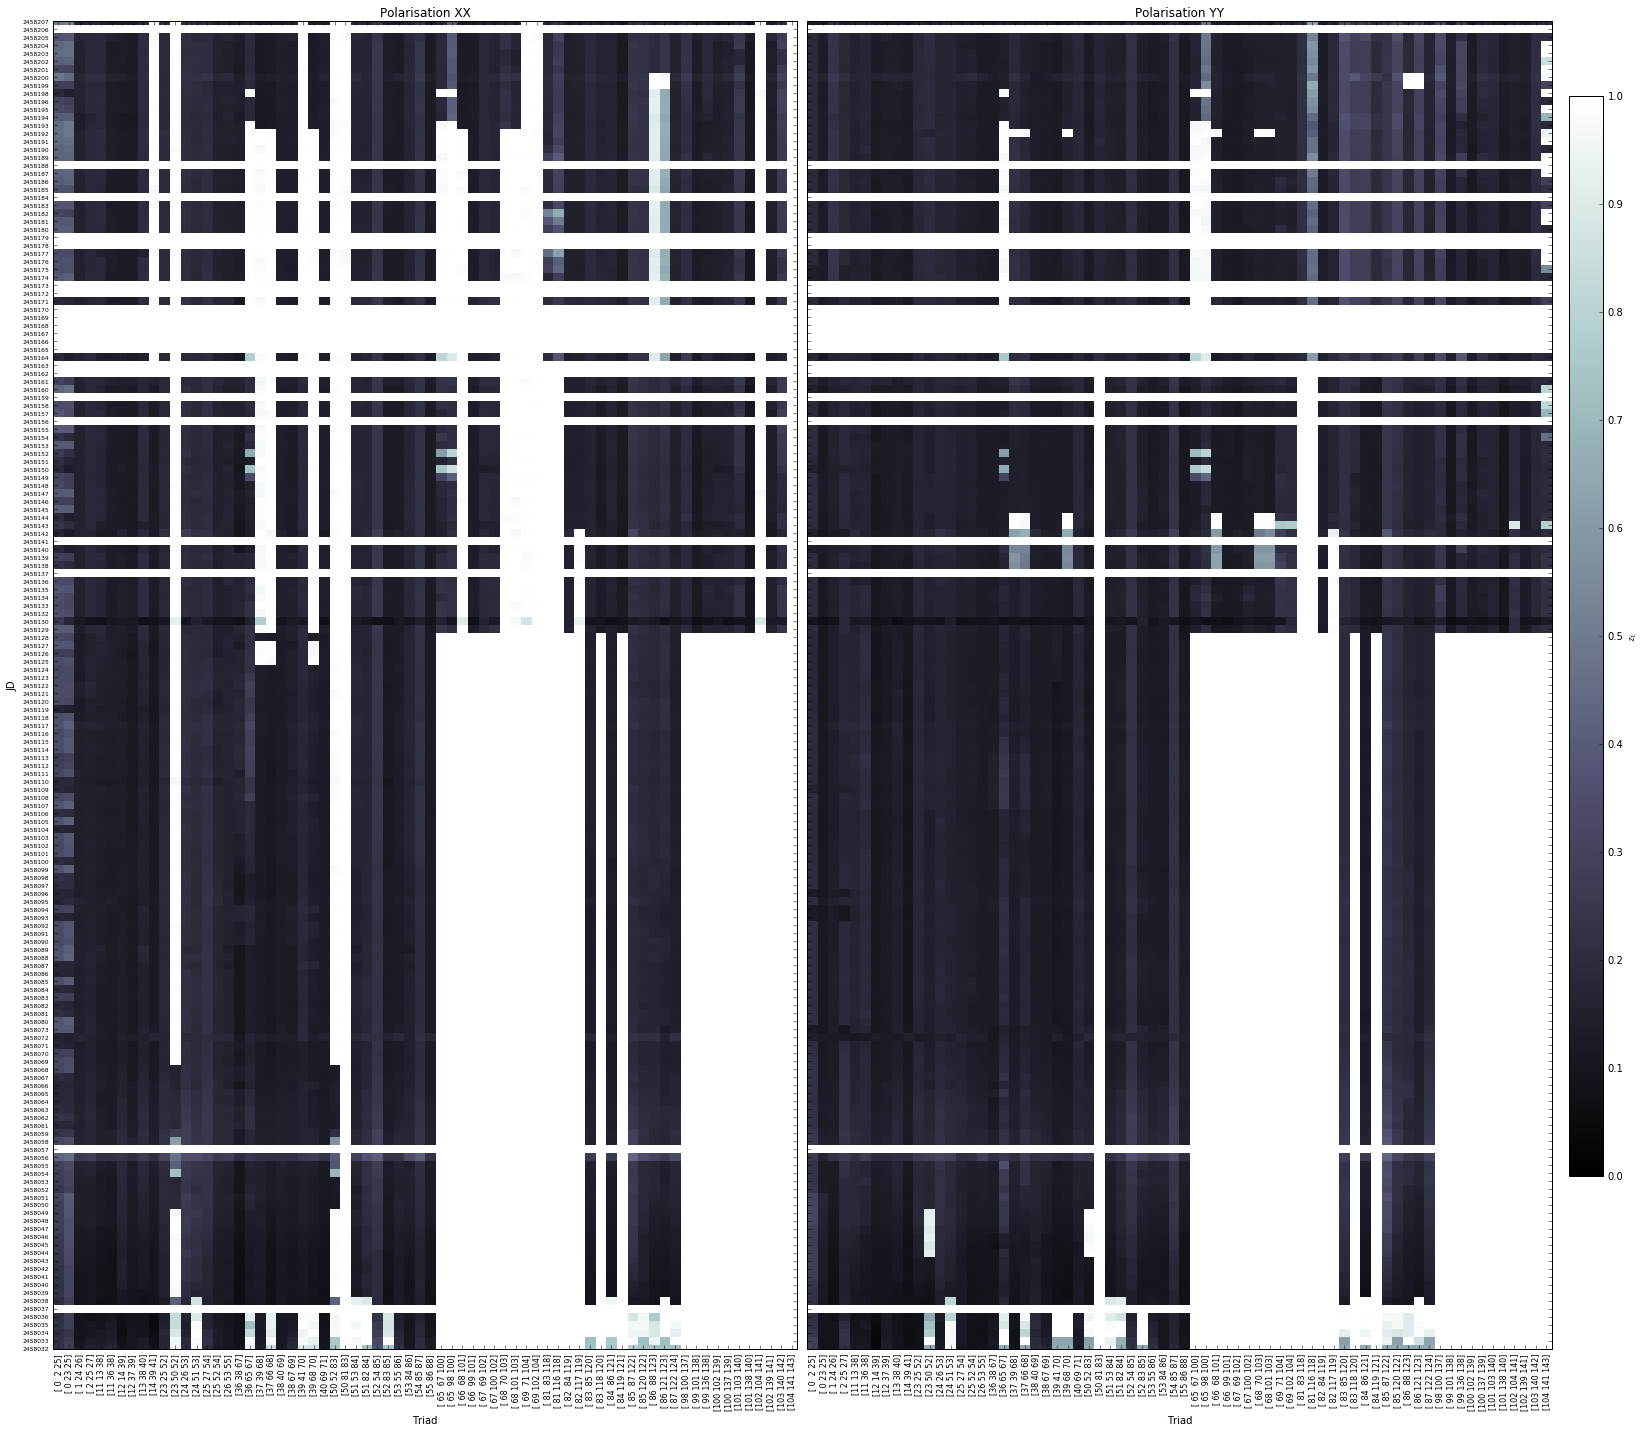

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(24, 20), sharey=True)
im1 = ax[0].imshow(z[0], aspect="auto", interpolation="None", cmap=cm.bone, vmin=0, vmax=1)
im2 = ax[1].imshow(z[1], aspect="auto", interpolation="None", cmap=cm.bone, vmin=0, vmax=1)

ax[0].set_ylabel("JD")
ax[0].set_yticklabels(jd, fontsize=6)
ax[0].set_xticklabels(trlist, fontsize=8, rotation=90)
ax[1].set_xticklabels(trlist, fontsize=8, rotation=90)
ax[0].set_title("Polarisation XX")
ax[1].set_title("Polarisation YY")

plt.setp(ax, 
         xlabel="Triad",
         xticks=np.arange(0, len(trlist), 1.0),
         yticks=np.arange(0, len(jd), 1.0))

plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.18, 0.02, 0.75])
fig.colorbar(im2, cax=cbar_ax, label=r"$z_1$")


### flag data
Flag JD and triads with z>=0.6 and all JD a triads that are flagged more than 60% and 70% of the time respectively.

In [ ]:
flags[np.where(z > 0.3)] = 1
flags[np.isnan(z)] = 1

# flags in both polarisations
jdfl = np.nanmean(np.max(flags, axis=0), axis=1)
trfl = np.nanmean(np.min(flags, axis=0), axis=0)
badjd = np.where((jdfl > 0.6) | (np.isnan(np.max(flags, axis=0)).mean(axis=1) > 0.6))[0]
badtr = np.where((trfl > 0.9) | (np.isnan(np.min(flags, axis=0)).mean(axis=0) > 0.9))[0]
flags[:, badjd] = 1
flags[:, :, badtr] = 1

# flag single polarisations
trfl = np.nanmean(flags, axis=1)
badpol, badtr = np.where(trfl > 0.8)
flags[badpol, :, badtr] = 1

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


## Metric: Non-Redundancy
Find triads that are poorly redundant with respect to the other triads

In [11]:
# median over JD
shape = bispec.shape[:1] + bispec.shape[2:]
bispecTR = np.zeros(shape).astype(np.complex128)
bispecFL = bispec.copy()
bispecFL[flags.astype(bool)] = np.nan

for p in range(2):
    for tr in range(len(trlist)):
        bispecTR[p, tr] = cp.geomed(bispecFL[p, :, tr], axis=0)
    
del bispecFL
print("median data has shape {}".format(bispecTR.shape))

median data has shape (2, 70, 62, 161)


### Distance Metric
(c.f. James Kent Thesis, "Redundancy")

In [29]:
bispecTR = np.moveaxis(bispecTR, 1, 0)
phaseD = np.angle(bispecTR[np.newaxis] * bispecTR[:, np.newaxis].conjugate())
bispecTR = np.moveaxis(bispecTR, 0, 1)
phaseD = np.moveaxis(np.abs(phaseD), 2, 0)
print(phaseD.shape)

mphaseD = np.nanmedian(phaseD, axis=(3, 4)) 
mphaseD = mphaseD / np.nanmedian(mphaseD)
print("distance metric has shape {}".format(mphaseD.shape))

(2, 70, 70, 62, 161)
distance metric has shape (2, 70, 70)


### Plot Metric

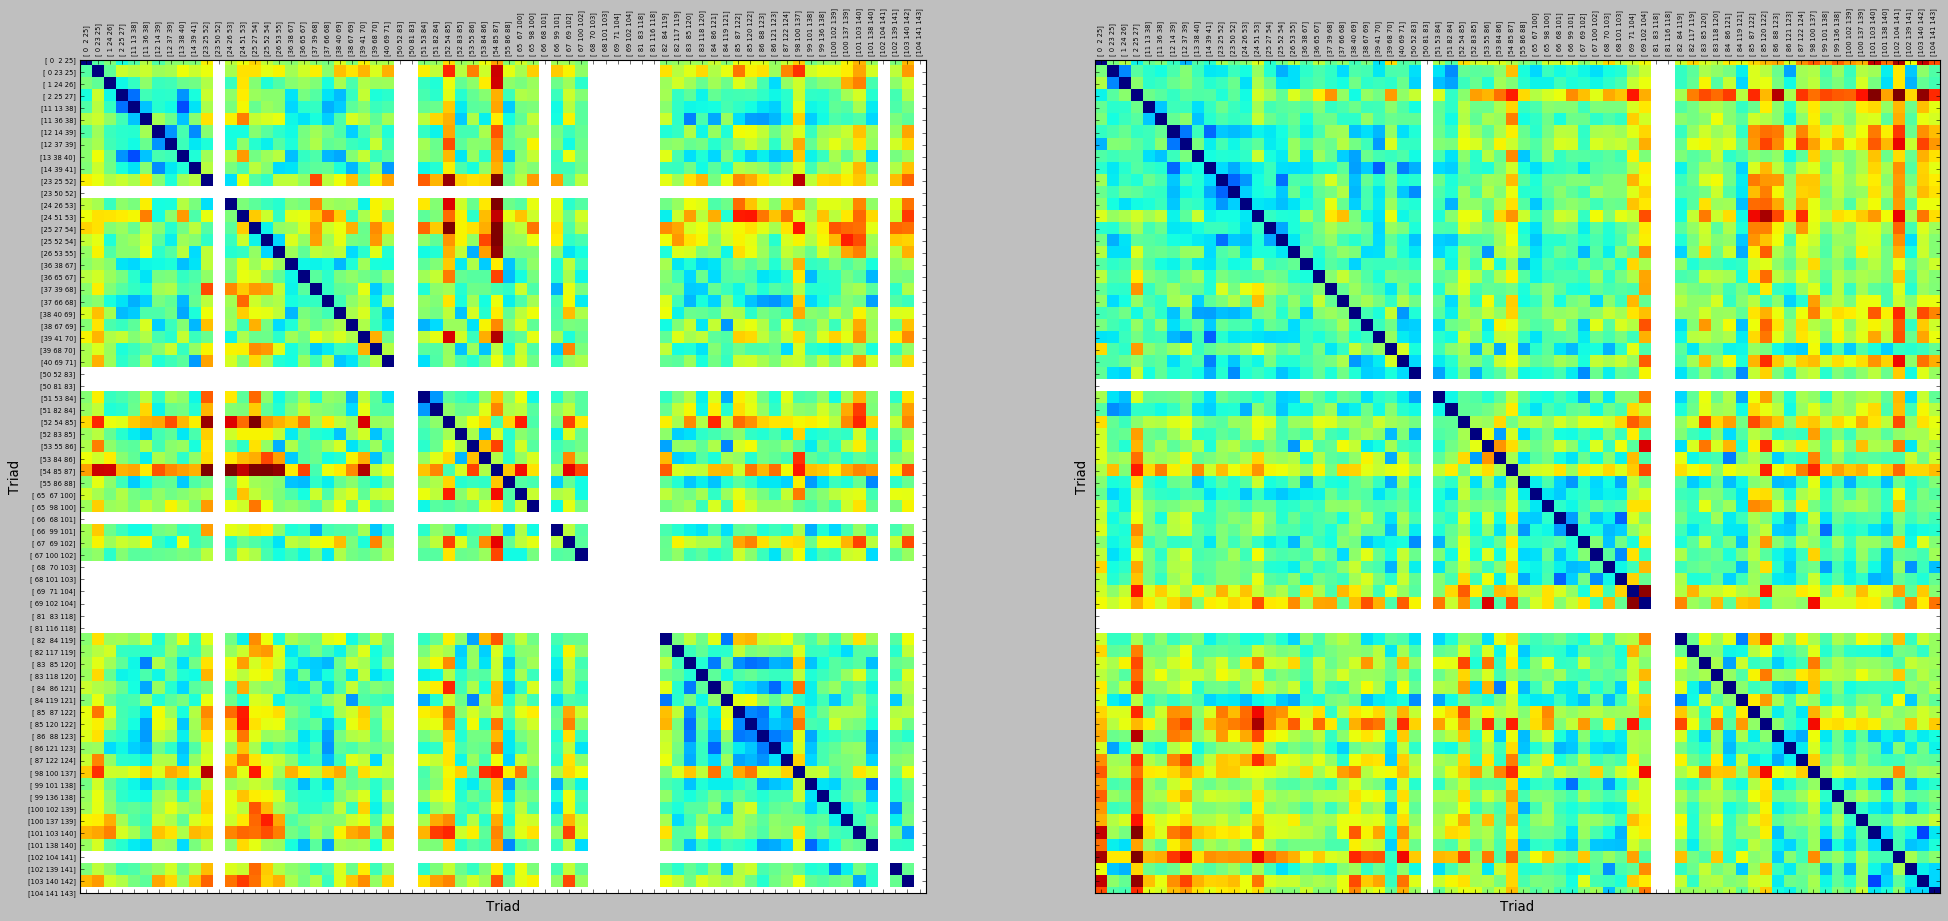

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(30, 20), sharey=True)
ax[0].matshow(mphaseD[0], vmin=0, vmax=2)
ax[1].matshow(mphaseD[1], vmin=0, vmax=2)
ax[0].set_xticklabels(trlist, fontsize=6, rotation=90)
ax[1].set_xticklabels(trlist, fontsize=6, rotation=90)
ax[0].set_yticklabels(trlist, fontsize=6)
ax[1].set_yticklabels(trlist, fontsize=6)
plt.setp(ax, 
         xlabel="Triad",
         ylabel="Triad",
         xticks=np.arange(0, len(trlist), 1.0),
         yticks=np.arange(0, len(trlist), 1.0)
        );

### flag poorly redundant triads

In [57]:
trred = np.nanmedian(mphaseD, axis=1)
trflags = trred > 1.2

### plot metric projected onto triad
The dashed lines are the flagging thresholds and the red bars are the flagged triads.

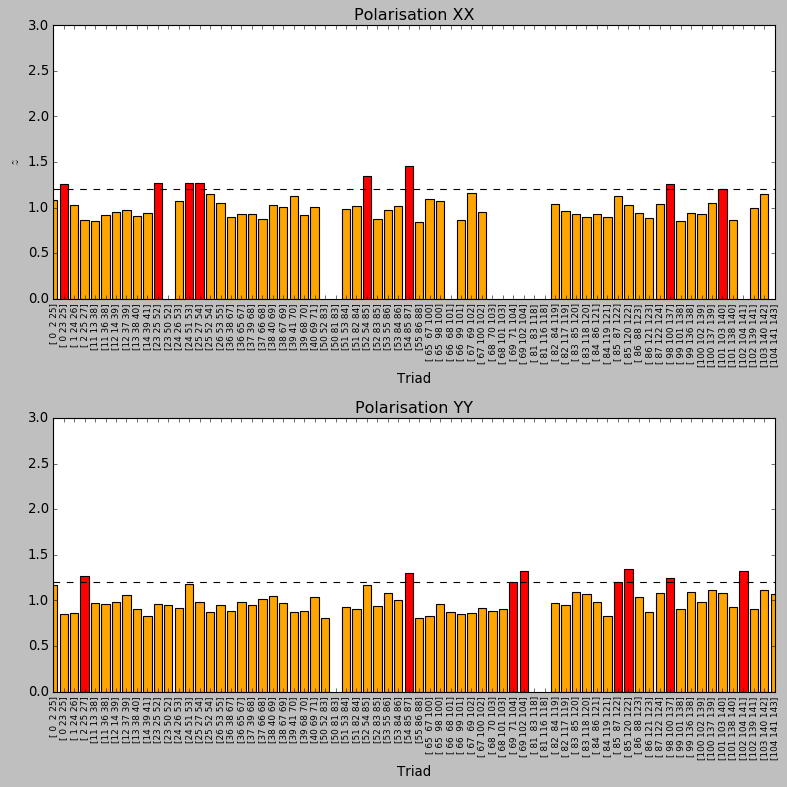

In [58]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].bar(np.arange(len(trlist))[~trflags[0]], trred[0, ~trflags[0]], color="orange")
ax[1].bar(np.arange(len(trlist))[~trflags[1]], trred[1, ~trflags[1]], color="orange")
ax[0].bar(np.arange(len(trlist))[trflags[0]], trred[0, trflags[0]], color="red")
ax[1].bar(np.arange(len(trlist))[trflags[1]], trred[1, trflags[1]], color="red")
ax[0].hlines(1.2, 0, len(trlist), linestyle="dashed")
ax[1].hlines(1.2, 0, len(trlist), linestyle="dashed")
ax[0].set_ylabel(r"$z$")
ax[0].set_title("Polarisation XX")
ax[1].set_title("Polarisation YY")
ax[0].set_xticklabels(trlist, fontsize=8, rotation=90)
ax[1].set_xticklabels(trlist, fontsize=8, rotation=90)

plt.setp(ax, xlabel="Triad", xlim=[0, len(trlist)-1], ylim=[0, 3], xticks=np.arange(0, len(trlist), 1.0),)
plt.tight_layout()

### minimum metric value per antenna
This allows to find bad antennas (e.g. antennas 0 and 2 in polarisations XX and YY respectively)

In [16]:
antlist = np.unique(trlist.reshape(-1))
trred = np.nanmean(mphaseD, axis=1)
antred = []

for ant in antlist:
    idx = np.unravel_index(np.where(np.in1d(trlist, [ant]))[0], trlist.shape)[0]
    antred.append(np.min(trred[:, idx], axis=1))
    
antred = np.moveaxis(antred, 0, 1)

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


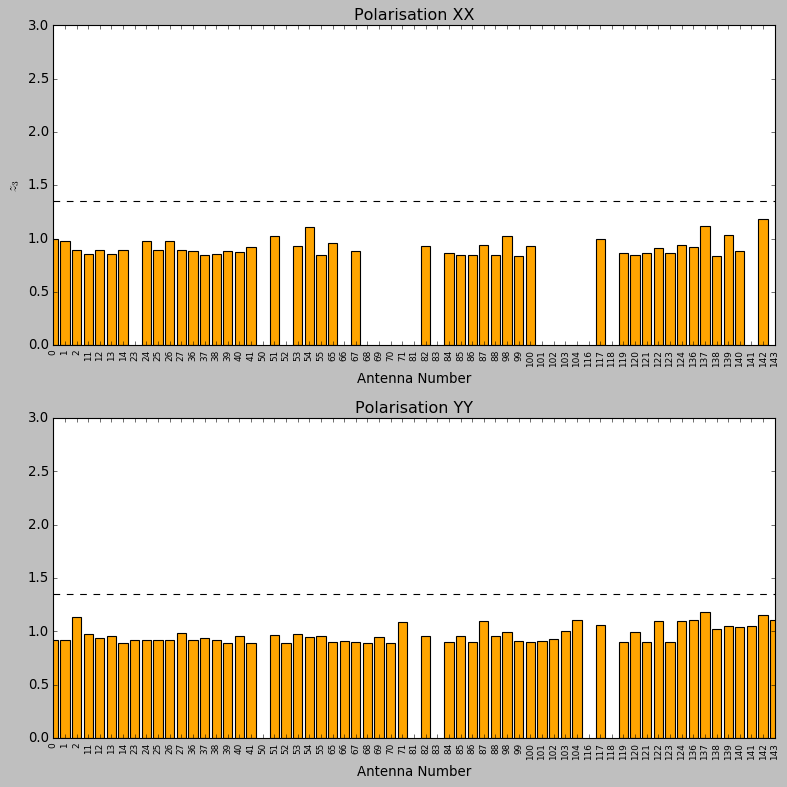

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].bar(np.arange(len(antlist)), antred[0], color="orange")
ax[1].bar(np.arange(len(antlist)), antred[1], color="orange")
ax[0].hlines(1.35, 0, len(antlist), linestyle="dashed")
ax[1].hlines(1.35, 0, len(antlist), linestyle="dashed")
ax[0].set_ylabel(r"$z_3$")
ax[0].set_title("Polarisation XX")
ax[1].set_title("Polarisation YY")
ax[0].set_xticklabels(antlist, fontsize=8, rotation=90)
ax[1].set_xticklabels(antlist, fontsize=8, rotation=90)

plt.setp(ax, xlabel="Antenna Number", xlim=[0, len(antlist)-1], ylim=[0, 3], xticks=np.arange(0, len(antlist), 1.0),)
plt.tight_layout()

### apply triad flags

In [18]:
idx = np.where(trflags)
flags[idx[0], :, idx[1]] = True

## Plot Flags
White portions of the data are flagged.

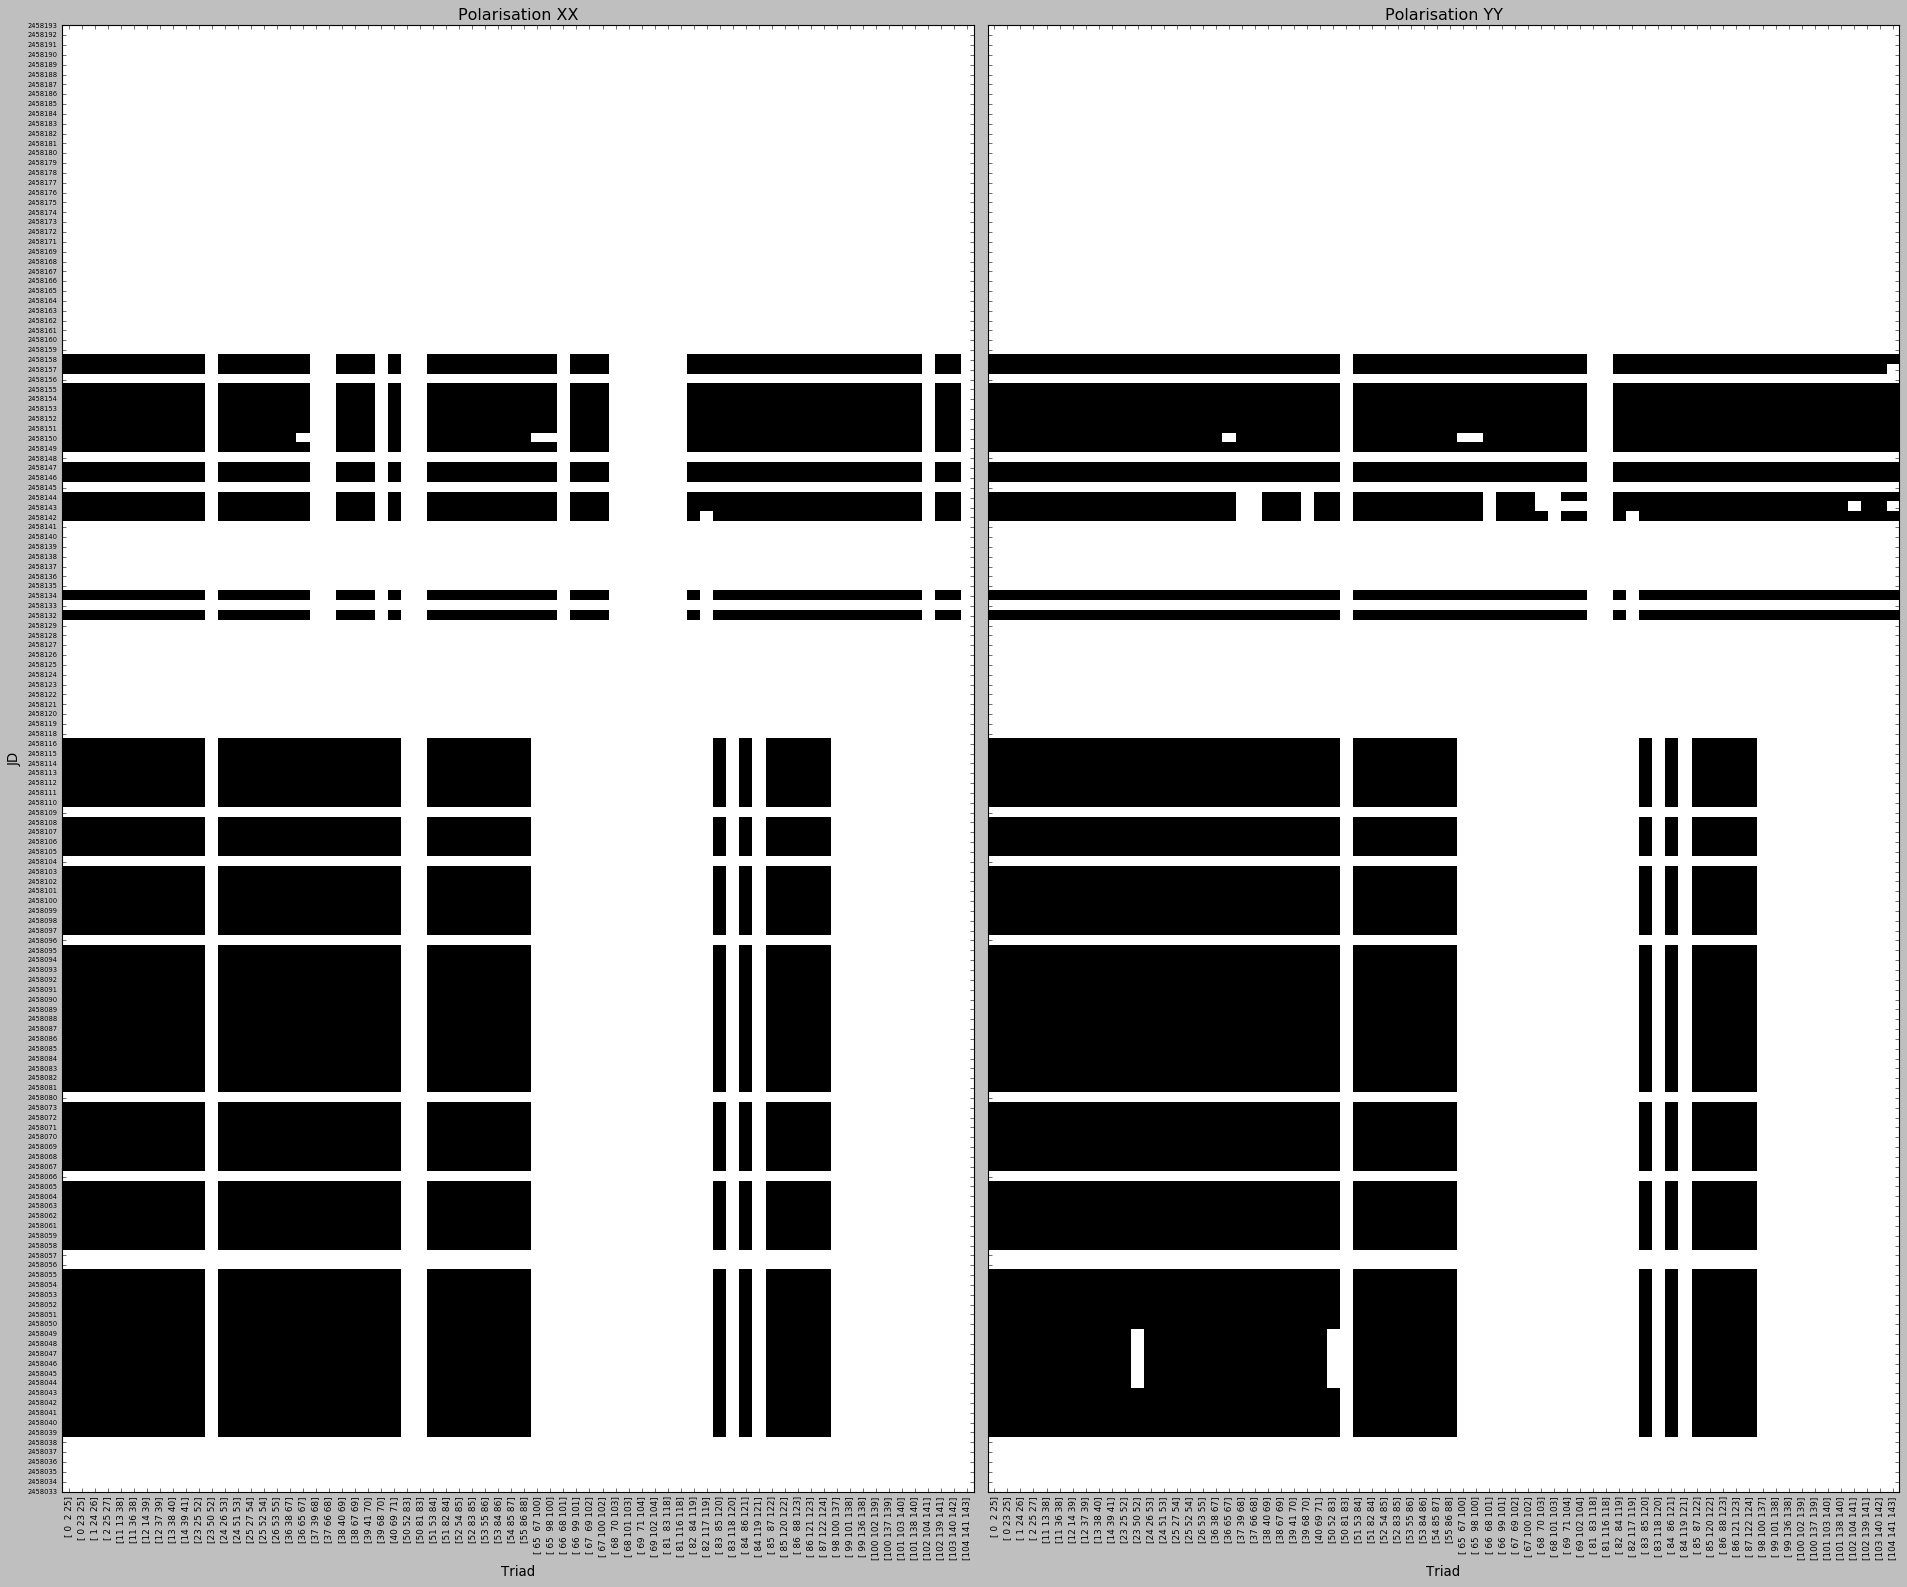

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(24, 20), sharey=True)
im1 = ax[0].imshow(flags[0], aspect="auto", interpolation="None", cmap=cm.bone)
im2 = ax[1].imshow(flags[1], aspect="auto", interpolation="None", cmap=cm.bone)

ax[0].set_ylabel("JD")
ax[0].set_yticklabels(jd, fontsize=6)
ax[0].set_xticklabels(trlist, fontsize=8, rotation=90)
ax[1].set_xticklabels(trlist, fontsize=8, rotation=90)
ax[0].set_title("Polarisation XX")
ax[1].set_title("Polarisation YY")

plt.setp(ax, 
         xlabel="Triad",
         xticks=np.arange(0, len(trlist), 1.0),
         yticks=np.arange(0, len(jd), 1.0))

plt.tight_layout()

## Write Flags to File

In [20]:
f = h5py.File(path, "a")
if "flags" in f.keys():
    del f["flags"]
f.create_dataset("flags", data=flags.astype(bool))
f.close()